# Convolutional Neural Network Modeling and Evaluation + Transfer Learning Comparison
*Run on Google Colaboratory VM*

#Colab env reqs

In [1]:
#Getting nb to run: Run this cell, then restart runtime
#https://stackoverflow.com/questions/71000120/colab-0-unimplemented-dnn-library-is-not-found
!pip install tensorflow==2.10
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


# Imports, Updates, etc.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython.display as ipd

from glob import glob
from PIL import Image

import librosa as lr
from librosa.display import waveplot, specshow
from librosa.core.spectrum import amplitude_to_db
from librosa.feature import melspectrogram

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, applications
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory, split_dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


# Classical Metrics for Comparison

In [4]:
classical_ML_mets = pd.read_csv('/content/drive/MyDrive/Springboard/Classical_ML_Metrics.csv', index_col='Unnamed: 0')
classical_ML_mets

,accuracy,cv best f1,test macro avg f1,Train AUC,Test AUC
KNearestNeighbors,0.615,0.603849,0.608323,0.965472,0.912458
LogisticRegression,0.700,0.685577,0.691909,0.979939,0.949750
SVM,0.705,0.710727,0.698152,0.999988,0.956889
XGBoost,0.725,0.686891,0.719013,1.000000,0.951889
GradientBoostingClassifier,0.700,0.687605,0.690294,1.000000,0.951528


# Load and Check Melspectrograms
(and generate replacement melspec for Jazz song 54)

In [5]:
melspec_folder = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms'

In [6]:
!ls '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms'

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [7]:
blues_pngs = glob(melspec_folder + '/blues/*.png')
classical_pngs = glob(melspec_folder + '/classical/*.png')
country_pngs = glob(melspec_folder + '/country/*.png')
disco_pngs = glob(melspec_folder + '/disco/*.png')
hiphop_pngs = glob(melspec_folder + '/hiphop/*.png')
jazz_pngs = glob(melspec_folder + '/jazz/*.png')
metal_pngs = glob(melspec_folder + '/metal/*.png')
pop_pngs = glob(melspec_folder + '/pop/*.png')
reggae_pngs = glob(melspec_folder + '/reggae/*.png')
rock_pngs = glob(melspec_folder + '/rock/*.png')

In [8]:
blues_pngs[:3]

['/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00031.png',
 '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00033.png',
 '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00028.png']

In [9]:
print(len(jazz_pngs))

100


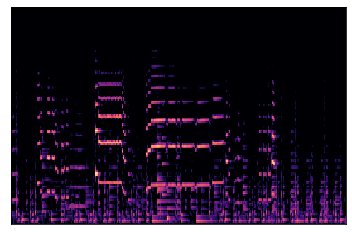

In [10]:
y, sr = lr.load('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/jazz/jazz.00054.wav') # Replacement melspec for corrupted Jazz song (no. 54)
time = np.arange(0, len(y)) / sr
y_melspec = melspectrogram(y, sr=sr)
melspec_db = amplitude_to_db(np.abs(y_melspec))
jazz_melspec = specshow(melspec_db, sr=sr, cmap='magma');
# plt.savefig('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')

Making sure the replacement melspectrogram resembles the others...

In [11]:
im = Image.open('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')
print(im.format, im.size, im.mode)

PNG (432, 288) RGBA


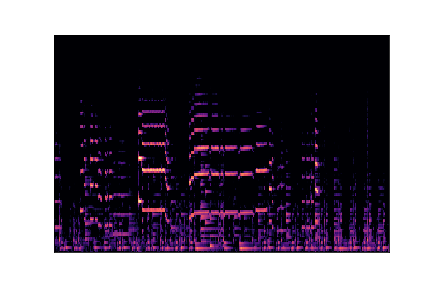

In [12]:
ipd.Image('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')

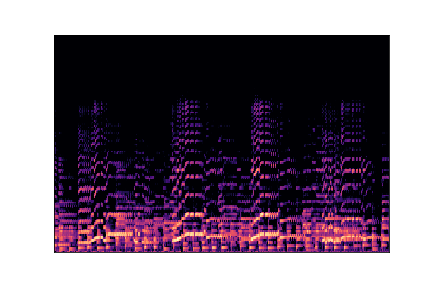

In [13]:
ipd.Image('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00055.png')

# Split into training, validation, and test datasets

In [14]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# https://github.com/keras-team/keras/issues/15985#issuecomment-1165831985

train_ds, test_ds = image_dataset_from_directory(melspec_folder,
                                             labels='inferred',
                                             label_mode = 'int',
                                             color_mode = 'rgb',
                                             image_size = (432, 288),
                                             validation_split = 0.2,
                                             subset = 'both',
                                             seed = 42)

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Using 200 files for validation.


In [15]:
# For future 'translation'
genre_dict = {0 : 'blues', 1 : 'classical', 2 : 'country', 3 : 'disco', 4 : 'hiphop', 5 : 'jazz', 6 : 'metal', 7 : 'pop', 8 : 'reggae', 9 : 'rock'}

In [16]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [17]:
tr_ds, val_ds = split_dataset(train_ds, left_size=0.9, right_size=0.1, shuffle=True, seed=42)

In [18]:
# Optimize for speed, utils.split_dataset() converts to PrefetchDataset, so only needed for unsplit test_ds
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
print(len(train_ds), len(test_ds), test_ds)
print(len(tr_ds), len(val_ds), val_ds)

25 7 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 432, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
23 3 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 432, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 432, 288, 3)
(32,)


Quick view of the melspecs:

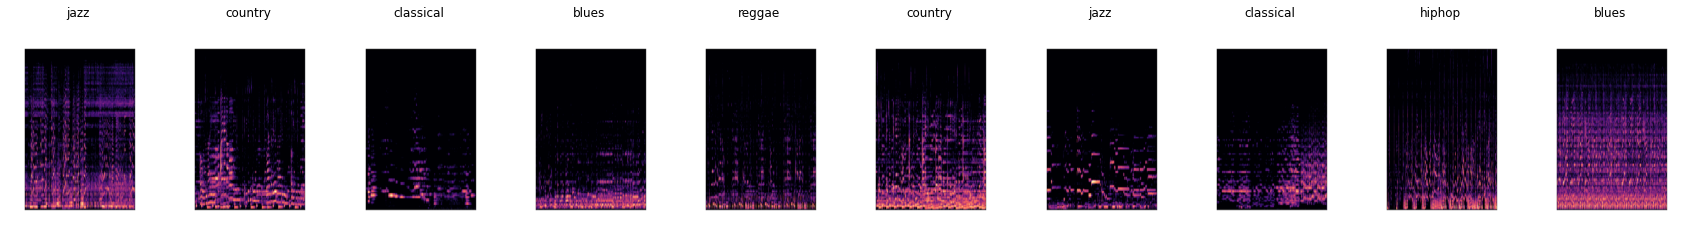

In [21]:
# https://www.tensorflow.org/tutorials/load_data/images

plt.figure(figsize=(30, 50))

for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Building our custom CNN

In [22]:
#https://www.tensorflow.org/tutorials/images/classification
batch_size, img_height, img_width, channels = (32, 432, 288, 3)

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2, seed=42))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0002) , loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 432, 288, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 432, 288, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 216, 144, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 216, 144, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 144, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 108, 72, 32)      0         
 2D)                                                    

#Train & Evaluate Custom CNN

In [23]:
earlyStopper = EarlyStopping(monitor='val_loss',
                             patience=7,
                             min_delta=0.0001,
                             restore_best_weights=True)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.9,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=5e-6, )

In [24]:
hist = model.fit(tr_ds, validation_data=val_ds, epochs=150, callbacks=[reduceLROnPlat, earlyStopper])

Epoch 1/150
23/23 [==============================] - 5s 96ms/step - loss: 15.0132 - accuracy: 0.0958 - val_loss: 11.7071 - val_accuracy: 0.0875 - lr: 2.0000e-04
Epoch 2/150
23/23 [==============================] - 2s 68ms/step - loss: 9.9283 - accuracy: 0.1056 - val_loss: 8.3995 - val_accuracy: 0.0875 - lr: 2.0000e-04
Epoch 3/150
23/23 [==============================] - 2s 66ms/step - loss: 7.6270 - accuracy: 0.1153 - val_loss: 6.9519 - val_accuracy: 0.0875 - lr: 2.0000e-04
Epoch 4/150
23/23 [==============================] - 1s 65ms/step - loss: 6.5536 - accuracy: 0.1333 - val_loss: 6.1800 - val_accuracy: 0.1125 - lr: 2.0000e-04
Epoch 5/150
23/23 [==============================] - 1s 65ms/step - loss: 5.8545 - accuracy: 0.2097 - val_loss: 5.6515 - val_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 6/150
23/23 [==============================] - 1s 62ms/step - loss: 5.4106 - accuracy: 0.2569 - val_loss: 5.2430 - val_accuracy: 0.2250 - lr: 2.0000e-04
Epoch 7/150
23/23 [=========================

In [25]:
score = model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 2.282487154006958 and val_acc = 0.5649999976158142


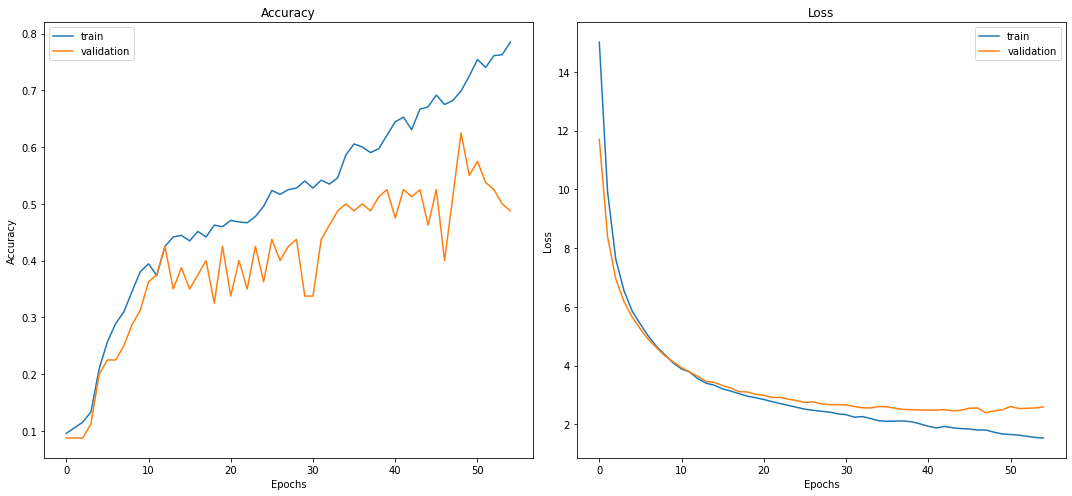

In [26]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
model.save('/content/drive/MyDrive/Springboard/SavedModel/custom_cnn.h5')

In [28]:
y_true = []

for i, j in list(test_ds.take(-1)):
  for arr in j:
    y_true.append(arr.numpy())

print(len(y_true), type(y_true[0]))

200 <class 'numpy.int32'>


In [29]:
y_true_str = [genre_dict[i] for i in y_true]

print(len(y_true_str), type(y_true_str[0]))

200 <class 'str'>


In [30]:
y_pred_arrs = model.predict(test_ds, verbose=0)

y_pred = []

for i in range(len(y_pred_arrs)):
  y_pred.append(np.argmax(y_pred_arrs[i]))

print(len(y_pred), type(y_pred[0]))

200 <class 'numpy.int64'>


In [31]:
y_pred_str = [genre_dict[i] for i in y_pred]

print(len(y_pred_str), type(y_pred_str[0]))

200 <class 'str'>


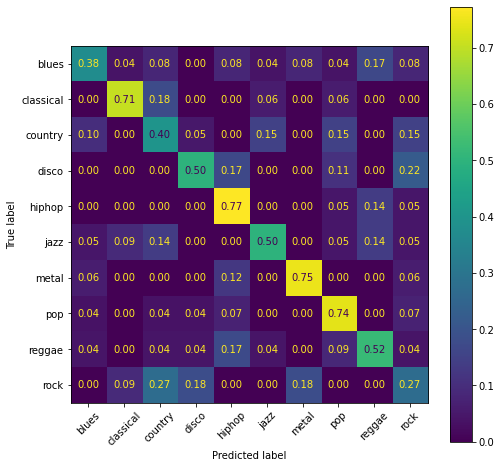

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               normalize='true',
                                               values_format='.2f',
                                               xticks_rotation=45,
                                               ax=ax)

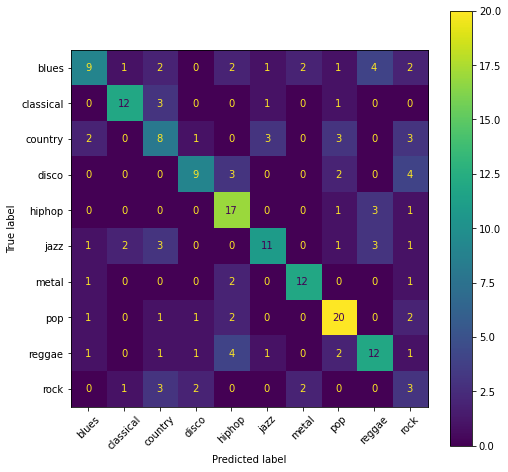

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               xticks_rotation=45,
                                               ax=ax)

In [34]:
customCNN_metrics = {
    'Custom_CNN': [classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['accuracy'],
                   np.nan,
                   classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['macro avg']['f1-score'],
                   np.nan,
                   np.nan]
    }

#Transfer Learning Evaluation:
ResNet50, Mobile Net, VGG16

#ResNet50:

In [35]:
ResNet_inner = tf.keras.applications.ResNet50(weights='imagenet',
                                              input_shape=(img_height, img_width, channels),
                                              include_top=False)

ResNet_inner.trainable = False

input_ = tf.keras.Input(shape=(img_height, img_width, channels))
x = tf.keras.applications.resnet50.preprocess_input(input_)
x = ResNet_inner(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_ = tf.keras.layers.Dense(10, activation='softmax')(x)
ResNet_model = tf.keras.Model(input_, output_)

ResNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

print(len(ResNet_model.trainable_variables), len(ResNet_model.layers))

ResNet_model.summary()

2 6
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 432, 288, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 432, 288, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 14, 9, 2048)       23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 10)                20

In [36]:
earlyStopper = EarlyStopping(monitor='val_loss',
                             patience=7,
                             min_delta=0.001,
                             restore_best_weights=True)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.001,
    cooldown=2,
    min_lr=5e-6, )

hist = ResNet_model.fit(tr_ds, validation_data=val_ds, epochs=80, callbacks=[reduceLROnPlat, earlyStopper])

Epoch 1/80
23/23 [==============================] - 8s 216ms/step - loss: 2.5264 - accuracy: 0.1139 - val_loss: 2.3103 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/80
23/23 [==============================] - 3s 147ms/step - loss: 2.2373 - accuracy: 0.1722 - val_loss: 2.0676 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 3/80
23/23 [==============================] - 3s 147ms/step - loss: 2.0936 - accuracy: 0.2333 - val_loss: 1.9469 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 4/80
23/23 [==============================] - 3s 146ms/step - loss: 1.9919 - accuracy: 0.2958 - val_loss: 1.8640 - val_accuracy: 0.4125 - lr: 1.0000e-04
Epoch 5/80
23/23 [==============================] - 3s 147ms/step - loss: 1.9078 - accuracy: 0.3639 - val_loss: 1.7920 - val_accuracy: 0.4375 - lr: 1.0000e-04
Epoch 6/80
23/23 [==============================] - 3s 147ms/step - loss: 1.8353 - accuracy: 0.4139 - val_loss: 1.7304 - val_accuracy: 0.4625 - lr: 1.0000e-04
Epoch 7/80
23/23 [============================

In [37]:
score = ResNet_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 1.0826681852340698 and val_acc = 0.6449999809265137


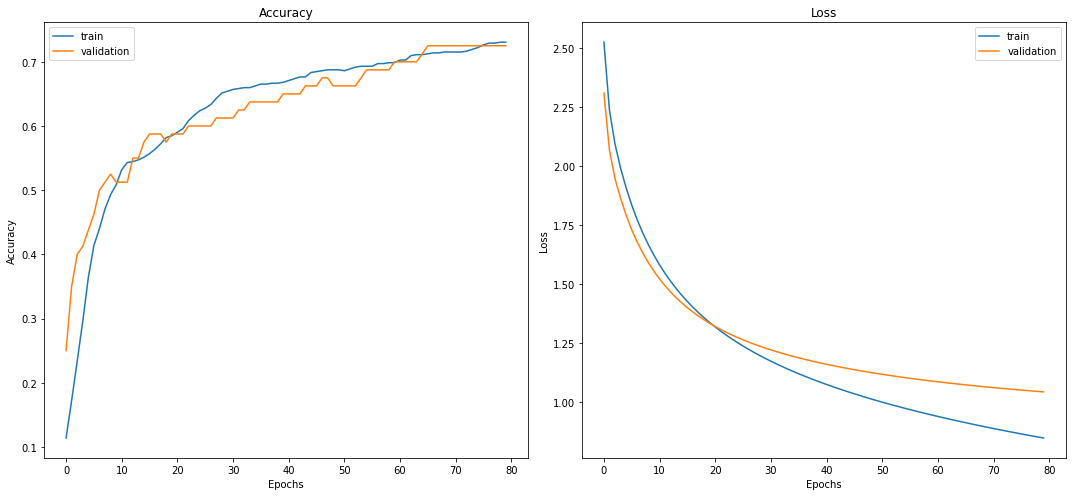

In [38]:
plt.figure(figsize=(15,7))

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.subplot(1,2,1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##ResNet Fine-Tuning & Evaluation

In [39]:
ResNet_inner.trainable = True

ResNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy']
                        )

print(len(ResNet_inner.trainable_variables), len(ResNet_inner.layers))

ResNet_model.summary()

212 175
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 432, 288, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 432, 288, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 14, 9, 2048)       23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 10)              

In [40]:
initial_epochs = len(hist.epoch)
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

hist_fine = ResNet_model.fit(tr_ds, validation_data = val_ds, epochs=total_epochs, initial_epoch=hist.epoch[-1])

Epoch 80/90
23/23 [==============================] - 18s 500ms/step - loss: 2.2635 - accuracy: 0.3569 - val_loss: 1.6468 - val_accuracy: 0.4625
Epoch 81/90
23/23 [==============================] - 10s 427ms/step - loss: 1.4001 - accuracy: 0.4889 - val_loss: 1.2609 - val_accuracy: 0.6000
Epoch 82/90
23/23 [==============================] - 10s 427ms/step - loss: 1.0718 - accuracy: 0.6028 - val_loss: 1.2260 - val_accuracy: 0.5875
Epoch 83/90
23/23 [==============================] - 10s 427ms/step - loss: 0.8706 - accuracy: 0.6903 - val_loss: 1.2182 - val_accuracy: 0.6250
Epoch 84/90
23/23 [==============================] - 10s 427ms/step - loss: 0.7661 - accuracy: 0.7306 - val_loss: 1.2120 - val_accuracy: 0.5500
Epoch 85/90
23/23 [==============================] - 10s 427ms/step - loss: 0.7143 - accuracy: 0.7472 - val_loss: 1.3992 - val_accuracy: 0.5750
Epoch 86/90
23/23 [==============================] - 10s 427ms/step - loss: 0.6220 - accuracy: 0.7708 - val_loss: 1.0475 - val_accuracy:

In [41]:
score = ResNet_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 1.0772407054901123 and val_acc = 0.7049999833106995


In [42]:
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

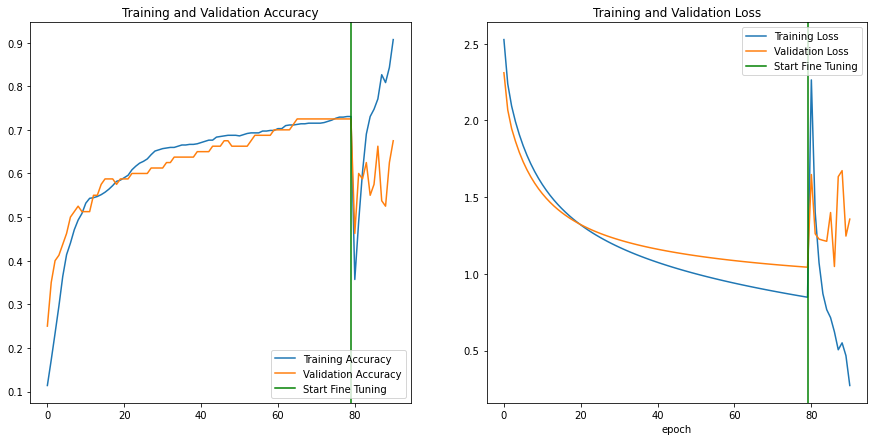

In [43]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

In [44]:
y_pred_arrs = ResNet_model.predict(test_ds, verbose=0)

y_pred = []

for i in range(len(y_pred_arrs)):
  y_pred.append(np.argmax(y_pred_arrs[i]))

y_pred_str = [genre_dict[i] for i in y_pred]

print(len(y_pred_str), type(y_pred_str[0]))

200 <class 'str'>


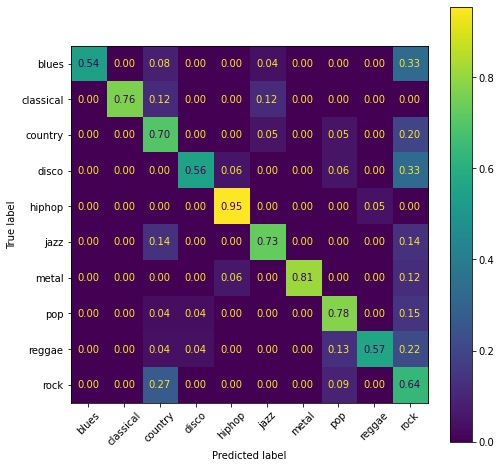

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               normalize='true',
                                               values_format='.2f',
                                               xticks_rotation=45,
                                               ax=ax)

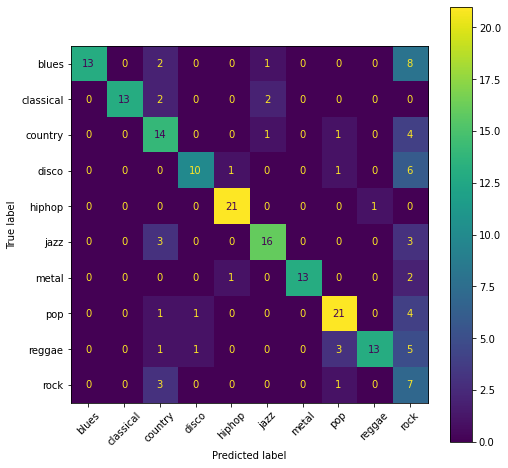

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               xticks_rotation=45,
                                               ax=ax)

In [47]:
ResNet_metrics = {
    'ResNet50': [classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['accuracy'],
                 np.nan,
                 classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['macro avg']['f1-score'],
                 np.nan,
                 np.nan]
    }

#MobileNetV2:



In [48]:
MobileNet_inner = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                 include_top=False,
                                                                 weights='imagenet'
                                                                 )

MobileNet_inner.trainable = False
print(len(MobileNet_inner.trainable_variables), len(MobileNet_inner.layers))

0 154


In [49]:
inputs = tf.keras.Input(shape=(img_height, img_width, channels))
x = tf.keras.layers.Resizing(224, 224)(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)
x = MobileNet_inner(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

MobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy']
                        )

MobileNet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [50]:
earlyStopper = EarlyStopping(monitor='val_loss',
                             patience=7,
                             min_delta=0.001,
                             restore_best_weights=True)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.001,
    cooldown=2,
    min_lr=5e-6, )

hist = MobileNet_model.fit(tr_ds, validation_data=val_ds, epochs=80, callbacks=[reduceLROnPlat, earlyStopper])

Epoch 1/80
23/23 [==============================] - 5s 93ms/step - loss: 2.6085 - accuracy: 0.0917 - val_loss: 2.4383 - val_accuracy: 0.1750 - lr: 1.0000e-04
Epoch 2/80
23/23 [==============================] - 1s 49ms/step - loss: 2.3596 - accuracy: 0.1528 - val_loss: 2.3143 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/80
23/23 [==============================] - 1s 49ms/step - loss: 2.2601 - accuracy: 0.1847 - val_loss: 2.2135 - val_accuracy: 0.2125 - lr: 1.0000e-04
Epoch 4/80
23/23 [==============================] - 1s 49ms/step - loss: 2.1459 - accuracy: 0.2264 - val_loss: 2.1207 - val_accuracy: 0.2375 - lr: 1.0000e-04
Epoch 5/80
23/23 [==============================] - 1s 49ms/step - loss: 2.0838 - accuracy: 0.2347 - val_loss: 2.0398 - val_accuracy: 0.2625 - lr: 1.0000e-04
Epoch 6/80
23/23 [==============================] - 1s 49ms/step - loss: 1.9731 - accuracy: 0.2931 - val_loss: 1.9654 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 7/80
23/23 [==============================] - 

In [51]:
score = MobileNet_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 1.0780668258666992 and val_acc = 0.6650000214576721


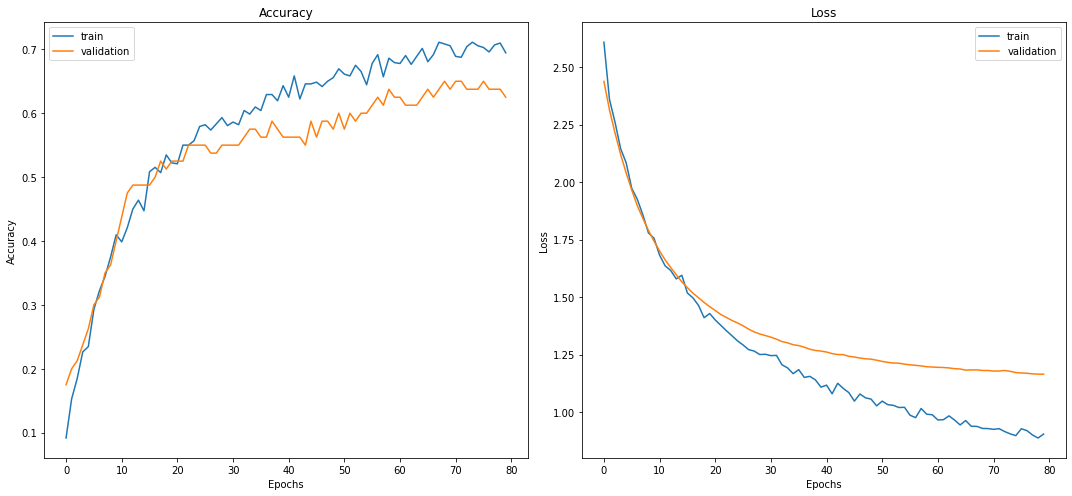

In [52]:
plt.figure(figsize=(15,7))

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.subplot(1,2,1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##MobileNet Fine-Tuning & Evaluation

In [53]:
MobileNet_inner.trainable = True

MobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy']
                        )

print(len(MobileNet_inner.trainable_variables), len(MobileNet_inner.layers))

MobileNet_model.summary()

156 154
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                   

In [54]:
initial_epochs = len(hist.epoch)
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

hist_fine = MobileNet_model.fit(tr_ds, validation_data = val_ds, epochs=total_epochs, initial_epoch=hist.epoch[-1])

Epoch 80/90
23/23 [==============================] - 8s 157ms/step - loss: 1.8349 - accuracy: 0.4472 - val_loss: 1.3949 - val_accuracy: 0.4750
Epoch 81/90
23/23 [==============================] - 3s 115ms/step - loss: 1.2175 - accuracy: 0.5681 - val_loss: 1.2325 - val_accuracy: 0.5750
Epoch 82/90
23/23 [==============================] - 3s 115ms/step - loss: 0.9576 - accuracy: 0.6708 - val_loss: 1.4681 - val_accuracy: 0.5375
Epoch 83/90
23/23 [==============================] - 3s 115ms/step - loss: 0.8543 - accuracy: 0.7264 - val_loss: 1.6178 - val_accuracy: 0.5125
Epoch 84/90
23/23 [==============================] - 3s 115ms/step - loss: 0.7603 - accuracy: 0.7278 - val_loss: 1.2209 - val_accuracy: 0.5875
Epoch 85/90
23/23 [==============================] - 3s 115ms/step - loss: 0.5730 - accuracy: 0.8111 - val_loss: 1.2459 - val_accuracy: 0.6375
Epoch 86/90
23/23 [==============================] - 3s 115ms/step - loss: 0.4713 - accuracy: 0.8333 - val_loss: 1.4803 - val_accuracy: 0.5375

In [55]:
score = MobileNet_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 1.2776856422424316 and val_acc = 0.625


In [56]:
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

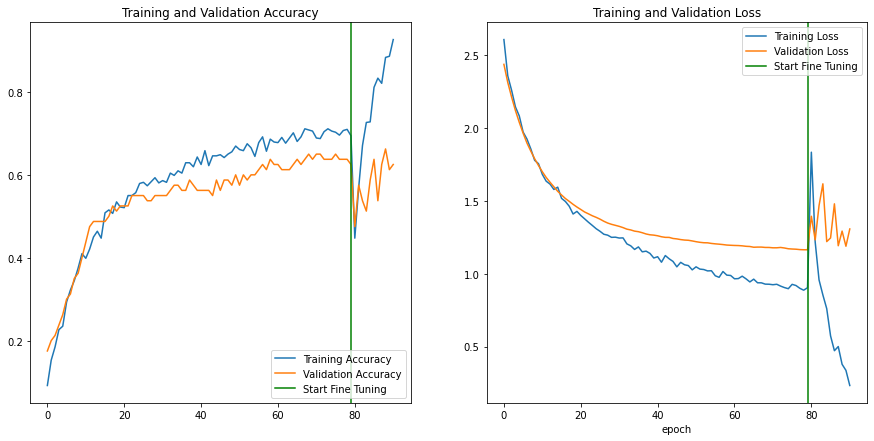

In [57]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

In [58]:
y_pred_arrs = MobileNet_model.predict(test_ds, verbose=0)

y_pred = []

for i in range(len(y_pred_arrs)):
  y_pred.append(np.argmax(y_pred_arrs[i]))

y_pred_str = [genre_dict[i] for i in y_pred]

print(len(y_pred_str), type(y_pred_str[0]))

200 <class 'str'>


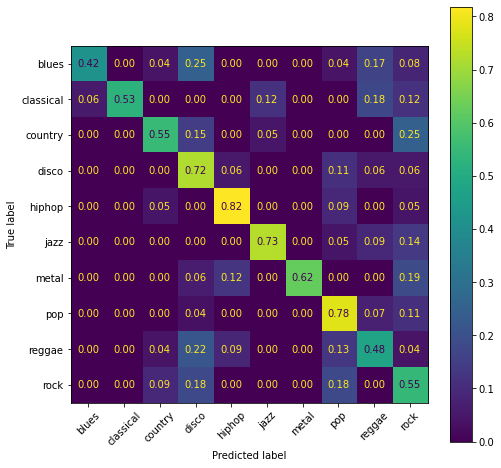

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               normalize='true',
                                               values_format='.2f',
                                               xticks_rotation=45,
                                               ax=ax)

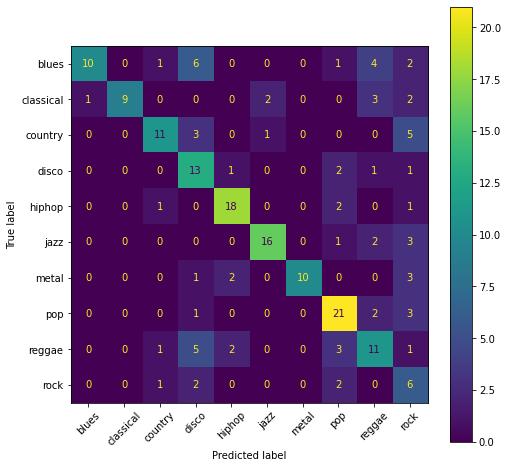

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               xticks_rotation=45,
                                               ax=ax)

In [61]:
MobileNet_metrics = {
    'MobileNetV2': [classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['accuracy'],
                    np.nan,
                    classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['macro avg']['f1-score'],
                    np.nan,
                    np.nan]
                     }

#VGG16:

In [62]:
vgg16_inner = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                weights='imagenet',
                                                input_shape=(224, 224, 3)
                                                )

vgg16_inner.trainable = False

print(len(vgg16_inner.trainable_variables), len(vgg16_inner.layers))

0 19


In [63]:
inputs = tf.keras.Input(shape=(img_height, img_width, channels))
x = tf.keras.layers.Resizing(224, 224)(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = vgg16_inner(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
VGG16_model = Model(inputs, outputs)

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy']
                    )

VGG16_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

In [64]:
earlyStopper = EarlyStopping(monitor='val_loss',
                             patience=7,
                             min_delta=0.001,
                             restore_best_weights=True)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.001,
    cooldown=2,
    min_lr=5e-6, )

hist = VGG16_model.fit(tr_ds, validation_data=val_ds, epochs=15, callbacks=[reduceLROnPlat, earlyStopper])

Epoch 1/15
23/23 [==============================] - 8s 173ms/step - loss: 32.4876 - accuracy: 0.1639 - val_loss: 26.2232 - val_accuracy: 0.4125 - lr: 1.0000e-04
Epoch 2/15
23/23 [==============================] - 2s 87ms/step - loss: 24.6690 - accuracy: 0.3819 - val_loss: 21.6626 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 3/15
23/23 [==============================] - 2s 87ms/step - loss: 20.6885 - accuracy: 0.4194 - val_loss: 19.1553 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 4/15
23/23 [==============================] - 2s 87ms/step - loss: 18.0587 - accuracy: 0.5153 - val_loss: 17.4756 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 5/15
23/23 [==============================] - 2s 87ms/step - loss: 16.4880 - accuracy: 0.5694 - val_loss: 16.1770 - val_accuracy: 0.4625 - lr: 1.0000e-04
Epoch 6/15
23/23 [==============================] - 2s 87ms/step - loss: 15.5326 - accuracy: 0.5931 - val_loss: 15.4501 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 7/15
23/23 [=====================

In [65]:
score = VGG16_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 12.424068450927734 and val_acc = 0.6800000071525574


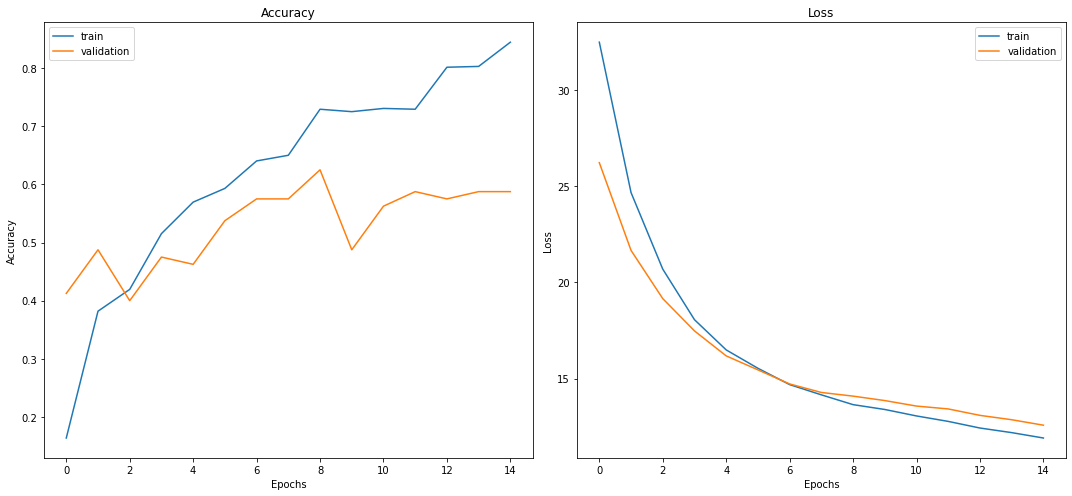

In [66]:
plt.figure(figsize=(15,7))

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.subplot(1,2,1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##VGG16 Fine-Tuning & Evaluation

In [67]:
vgg16_inner.trainable = True

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy']
                    )

print(len(vgg16_inner.trainable_variables), len(vgg16_inner.layers))

VGG16_model.summary()

26 19
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)           

In [68]:
initial_epochs = len(hist.epoch)
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

hist_fine = VGG16_model.fit(tr_ds, validation_data = val_ds, epochs=total_epochs, initial_epoch=hist.epoch[-1])

Epoch 15/25
23/23 [==============================] - 8s 258ms/step - loss: 13.0085 - accuracy: 0.2389 - val_loss: 12.2207 - val_accuracy: 0.2375
Epoch 16/25
23/23 [==============================] - 5s 221ms/step - loss: 11.7395 - accuracy: 0.3292 - val_loss: 11.4672 - val_accuracy: 0.3375
Epoch 17/25
23/23 [==============================] - 5s 221ms/step - loss: 11.0686 - accuracy: 0.4056 - val_loss: 10.7115 - val_accuracy: 0.4750
Epoch 18/25
23/23 [==============================] - 5s 221ms/step - loss: 10.4158 - accuracy: 0.4694 - val_loss: 10.1989 - val_accuracy: 0.4375
Epoch 19/25
23/23 [==============================] - 5s 221ms/step - loss: 9.8380 - accuracy: 0.5528 - val_loss: 9.7259 - val_accuracy: 0.5375
Epoch 20/25
23/23 [==============================] - 5s 221ms/step - loss: 9.5528 - accuracy: 0.5486 - val_loss: 9.7045 - val_accuracy: 0.4750
Epoch 21/25
23/23 [==============================] - 5s 220ms/step - loss: 9.3590 - accuracy: 0.5403 - val_loss: 9.2197 - val_accuracy

In [69]:
score = VGG16_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 8.524883270263672 and val_acc = 0.5199999809265137


In [70]:
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

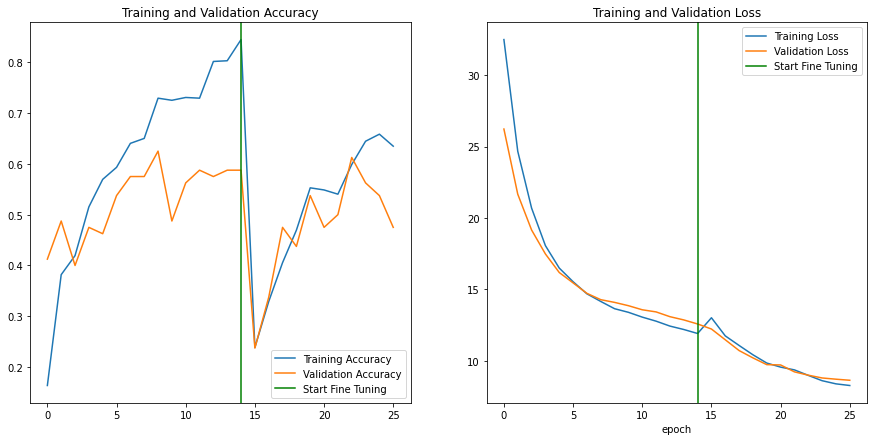

In [71]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

In [72]:
y_pred_arrs = VGG16_model.predict(test_ds, verbose=0)

y_pred = []

for i in range(len(y_pred_arrs)):
  y_pred.append(np.argmax(y_pred_arrs[i]))

y_pred_str = [genre_dict[i] for i in y_pred]

print(len(y_pred_str), type(y_pred_str[0]))

200 <class 'str'>


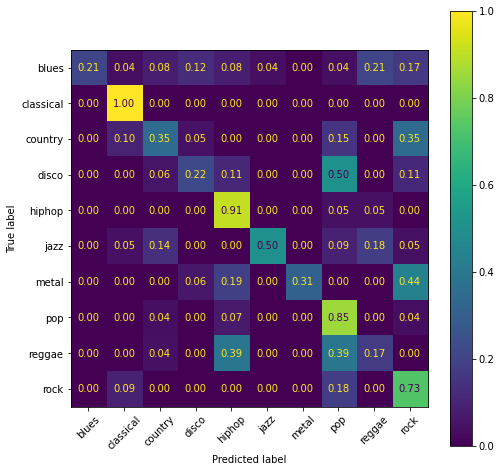

In [73]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               normalize='true',
                                               values_format='.2f',
                                               xticks_rotation=45,
                                               ax=ax)

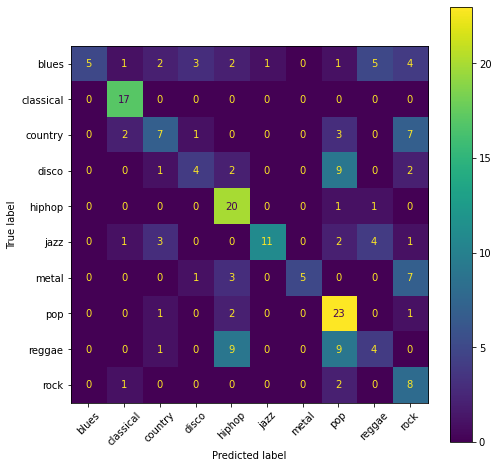

In [74]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               xticks_rotation=45,
                                               ax=ax)

In [75]:
VGG16_metrics = {
    'VGG16': [classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['accuracy'],
              np.nan,
              classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['macro avg']['f1-score'],
              np.nan,
              np.nan]
              }

#Metrics Summarized

In [76]:
# Metrics compiled / summarized for ALL models
mets_list = [customCNN_metrics, ResNet_metrics, MobileNet_metrics, VGG16_metrics]

new_mets={}

for i in mets_list:
  new_mets.update(i)

In [77]:
new_mets_df = pd.DataFrame.from_dict(new_mets, orient='index', columns = classical_ML_mets.columns)

all_metrics_df = pd.concat([classical_ML_mets, new_mets_df])

all_metrics_df

,accuracy,cv best f1,test macro avg f1,Train AUC,Test AUC
KNearestNeighbors,0.615,0.603849,0.608323,0.965472,0.912458
LogisticRegression,0.700,0.685577,0.691909,0.979939,0.949750
SVM,0.705,0.710727,0.698152,0.999988,0.956889
XGBoost,0.725,0.686891,0.719013,1.000000,0.951889
GradientBoostingClassifier,0.700,0.687605,0.690294,1.000000,0.951528
Custom_CNN,0.565,NaN,0.553939,NaN,NaN
ResNet50,0.705,NaN,0.719700,NaN,NaN
MobileNetV2,0.625,NaN,0.627855,NaN,NaN
VGG16,0.520,NaN,0.490670,NaN,NaN


In [78]:
all_metrics_df = all_metrics_df.drop(columns=['cv best f1', 'Train AUC', 'Test AUC'])
all_metrics_df = all_metrics_df.sort_values('accuracy', ascending=False)
all_metrics_df.to_csv('/content/drive/MyDrive/Springboard/All_Metrics.csv', index_label='Model')

In [79]:
check = pd.read_csv('/content/drive/MyDrive/Springboard/All_Metrics.csv', index_col=0)

check

,accuracy,test macro avg f1
Model,,
XGBoost,0.725,0.719013
SVM,0.705,0.698152
ResNet50,0.705,0.719700
LogisticRegression,0.700,0.691909
GradientBoostingClassifier,0.700,0.690294
MobileNetV2,0.625,0.627855
KNearestNeighbors,0.615,0.608323
Custom_CNN,0.565,0.553939
VGG16,0.520,0.490670
